In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dmitriysheremetev","key":"08a410d85ae6d62e8c10b6914bb4cb49"}'}

In [ ]:
!mkdir -p ~/.kaggle  # Создаем директорию для хранения ключа API
!mv kaggle.json ~/.kaggle/  # Перемещаем загруженный файл в нужную папку
!chmod 600 ~/.kaggle/kaggle.json  # Устанавливаем права доступа, чтобы API мог его читать

In [ ]:
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                         94KB  2024-09-02 10:53:57          29583        519  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           3962         73  1.0              
abdulszz/spotify-most-streamed-songs                          Spotify Most Streamed Songs                         60KB  2024-09-07 18:23:14          11329        149  1.0              
prajwaldongre/top-50-luxury-hotels-worldwide                  Top 50 Luxury

In [ ]:
!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models


Dataset URL: https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models
License(s): unknown
cats-faces-64x64-for-generative-models.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip cats-faces-64x64-for-generative-models -d ./cats

Archive:  cats-faces-64x64-for-generative-models.zip
replace ./cats/cats/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls ./cats

cats


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
import os
from PIL import Image

images = []

for dirpath, dirnames, filenames in os.walk("/content/cats"):
    for fname in filenames:
        if fname.endswith(".jpg"):
            fpath = os.path.join(dirpath, fname)
            image = Image.open(fpath)
            images.append(image)

In [ ]:
def plot_gallery(images, n_rows = 3, n_cols= 6, from_torch = False):
    if from_torch:
        images = [x.data.numpy().transpose(1,2,0) for x in images]
    plt.figure(figsize = (2 * n_cols, 2 * n_rows))
    for i in range(n_rows* n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.xticks(())
        plt.yticks(())
    plt.show()

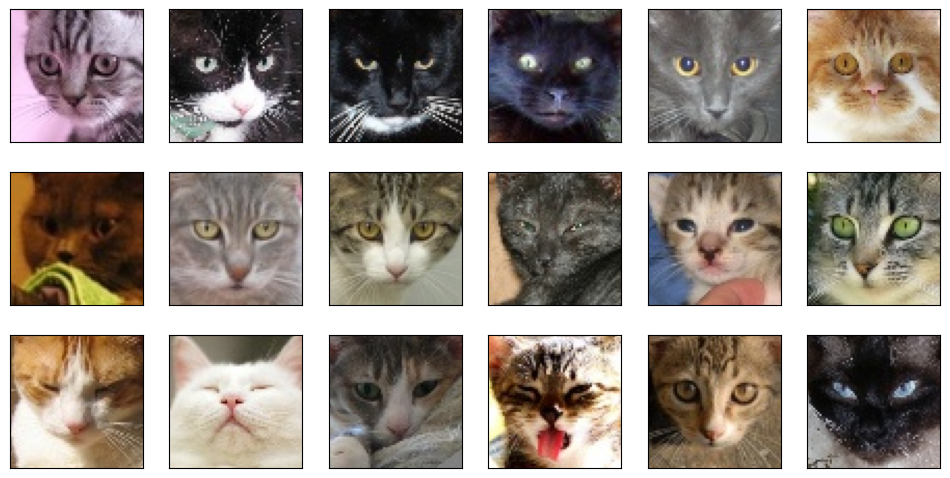

In [ ]:
plot_gallery(images)

In [ ]:
len(images)

31494

In [ ]:
np.array(images[0]).shape

(64, 64, 3)

In [ ]:
class Cats(torch.utils.data.Dataset):
    def __init__(self, cats, normStats = ((0.5, 0.5, 0.5),(0.5, 0.5,0.5))):
        self.data = cats
        self.transform = transforms.Compose([
                                             transforms.Resize((64,64)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(*normStats)
                                             ])
    def __getitem__(self, index):
        x = self.data[index]
        return self.transform(x).float()

    def __len__(self):
        return len(self.data)


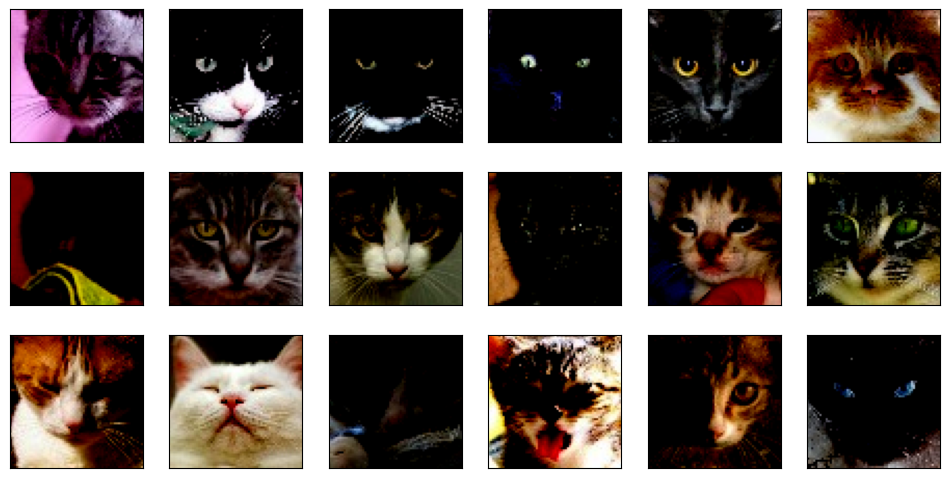

In [ ]:
stats = (0.5, 0.5, 0.5),(0.5,0.5,0.5)
dataset = Cats(images, normStats = stats)

plot_gallery(dataset, from_torch=True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16, shuffle = False)

In [ ]:
class G(nn.Module):
    def __init__(self, latent_size = 128):
        super(G, self).__init__()

        self.main = nn.Sequential(
                nn.ConvTranspose2d(latent_size, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )

    def forward(self, input):
        output = self.main(input)
        return output
latent_size = 128
netG = G(latent_size = latent_size).to(device)
#netG.apply(weights_init)

In [ ]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )

    def forward(self, input):
        output = self.main(input)
        return nn.Flatten()(output)


netD = D().to(device)
#netD.apply(weights_init)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device = device)

In [ ]:
from torchvision.utils import make_grid
def denorm(img_tensors, stats):
    return img_tensors * stats[1][0] + stats[0][0]

def show_samples(latent_tensors, model):
    fake_images = model(latent_tensors)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(make_grid(denorm(fake_images[:64].cpu().detach(), stats), nrow = 8).permute(1,2,0))
    plt.show()

In [ ]:
from IPython.display import clear_output
def train(models, opts, loss_fns, epochs, train_loader, val_loader, batch_size):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} / {epochs}")

        models["descriminator"].train()
        models["generator"].train()

        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for i, X_batch in enumerate(train_loader):
            X_batch = X_batch.to(device)

            opts["descriminator"].zero_grad()

            real_preds = models["descriminator"](X_batch)
            real_targets = torch.ones(X_batch.size(0), 1, device = device)
            real_loss = loss_fns["descriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
            fake_images = models["generator"](latent)
            fake_preds = models["descriminator"](fake_images)
            fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
            fake_loss = loss_fns["descriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = fake_loss + real_loss
            loss_d.backward()

            opts["descriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            opts["generator"].zero_grad()
            latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
            fake_images = models["generator"](latent)
            preds = models["descriminator"](fake_images)
            targets = torch.ones(fake_images.size(0), 1, device = device)

            loss_g = loss_fns["generator"](preds, targets)

            loss_g.backward()
            opts["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

            if i % 100 == 0:
                losses_g.append(np.mean(loss_g_per_epoch))
                losses_d.append(np.mean(loss_d_per_epoch))
                real_scores.append(np.mean(real_score_per_epoch))
                fake_scores.append(np.mean(fake_score_per_epoch))
                clear_output(wait = True)
                print(f"Epoch {epoch + 1} / {epochs}, losses_g {losses_g[-1]}, losses_d {losses_d[-1]}, real_scores {real_scores[-1]}, fake_scores {fake_scores[-1]}")

                show_samples(fixed_latent, models["generator"])
    return losses_g, losses_d, real_scores, fake_scores

Epoch 1 / 40, losses_g 7.848321914672852, losses_d 0.18652430176734924, real_scores 0.9674116373062134, fake_scores 0.1333319991827011


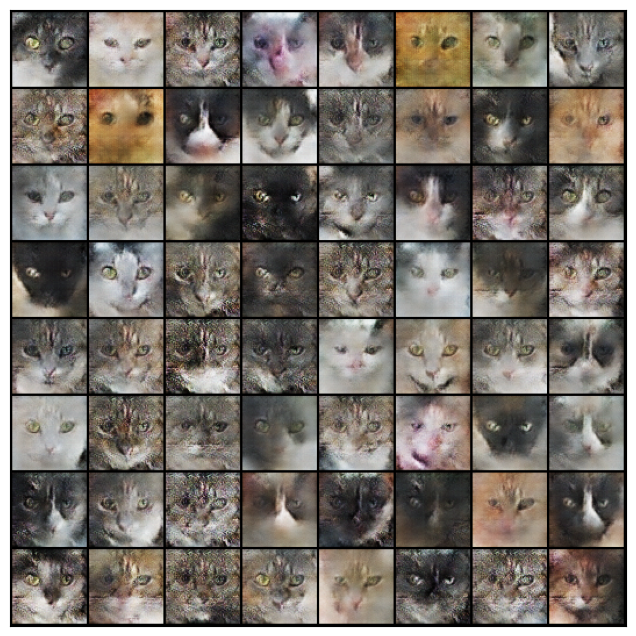

In [ ]:
models = {
    "generator" : netG,
    "descriminator" : netD
}
criterions = {
    "generator" : nn.BCELoss(),
    "descriminator" : nn.BCELoss()
}
lr = 0.00015
opts = {
    "generator" : torch.optim.Adam(models["generator"].parameters(), lr = lr, betas = (0.5, 0.999)),
    "descriminator" : torch.optim.Adam(models["descriminator"].parameters(), lr = lr, betas = (0.5, 0.999))
}
train(models, opts, criterions, 40, train_loader, val_loader, 16)